# Layer-CAM: Hierarchical Class Activation Maps

Improved visualization method that uses element-wise gradient weighting instead of global average pooling.

## Overview

LayerCAM (2021) improves on Grad-CAM:
- Multi-layer aggregation possible
- Better localization precision
- Handles multiple objects better
- Still efficient (1 forward + 1 backward pass)

### Advantages:

- Uses hierarchical features
- Better object boundaries
- More robust to occlusions
- Same computational cost as Grad-CAM

### Reference:

Jiang et al., "LayerCAM: Exploring Hierarchical Class Activation Maps for Localization", IEEE TIP 2021

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Layer-CAM Implementation

### Algorithm:

**Grad-CAM (baseline):**
$$L_{Grad-CAM}^c = ReLU\left(\sum_k w_k^c A^k\right)$$
where $w_k^c = \frac{1}{Z}\sum_i\sum_j \frac{\partial y^c}{\partial A_{ij}^k}$

**Layer-CAM (improved):**

For each spatial location $(i,j)$:
$$L_{Layer-CAM}^c(i,j) = ReLU\left(\sum_k \frac{\partial y^c}{\partial A_{ij}^k} \cdot A_{ij}^k\right)$$

**Key differences:**
1. Spatial weighting (not global average)
2. Element-wise multiplication
3. Preserves spatial information

In [2]:
class LayerCAM:
    # LayerCAM implementation using spatial gradient weighting
    # Reference: Jiang et al., IEEE TIP 2021
    
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)
    
    def generate_cam(
        self,
        image: torch.Tensor,
        target_class: Optional[int] = None
    ) -> np.ndarray:
        # generate Layer-CAM
        self.model.eval()
        image.requires_grad = True
        
        # forward pass
        output = self.model(image)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # zero gradients
        self.model.zero_grad()
        
        # backward pass
        target_score = output[0, target_class]
        target_score.backward()
        
        # Layer-CAM: element-wise multiplication of ReLU(gradients) and activations
        positive_gradients = torch.relu(self.gradients)
        
        # sum over channels
        cam = torch.sum(positive_gradients * self.activations, dim=1, keepdim=True)
        
        # apply ReLU
        cam = torch.relu(cam)
        
        # normalize
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
        
        return cam
    
    def visualize(
        self,
        image: torch.Tensor,
        cam: np.ndarray,
        alpha: float = 0.5
    ) -> np.ndarray:
        # overlay CAM on image
        img = image.squeeze().detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        
        # denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # resize CAM
        h, w = img.shape[:2]
        cam_resized = cv2.resize(cam, (w, h)).copy()
        
        # apply colormap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = heatmap / 255.0
        
        # overlay
        overlayed = alpha * heatmap + (1 - alpha) * img
        overlayed = np.clip(overlayed, 0, 1)
        
        return overlayed

print("✓ LayerCAM class defined successfully")

✓ LayerCAM class defined successfully


## Load Pre-trained Model

In [3]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Load ResNet-50
print("\nLoading ResNet-50...")
model = models.resnet50(weights='IMAGENET1K_V1')
model.eval()
model.to(device)

# Target layer (last convolutional layer)
target_layer = model.layer4[-1]

print(f"Model loaded: ResNet-50")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Target layer: layer4[-1]")

Device: cpu

Loading ResNet-50...
Model loaded: ResNet-50
Total parameters: 25,557,032
Target layer: layer4[-1]


## Initialize LayerCAM

In [4]:
# Initialize LayerCAM
layercam = LayerCAM(model=model, target_layer=target_layer)
print("LayerCAM initialized")

LayerCAM initialized


## Load and Preprocess Test Image

In [5]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load sample image
data_dir = Path('input_images')
image_files = list(data_dir.glob('*.jpg')) + list(data_dir.glob('*.png'))

if len(image_files) == 0:
    print("No images found. Please run: 1_create_dataset.ipynb")
else:
    # Load first image
    image_path = image_files[0]
    image_pil = Image.open(image_path).convert('RGB')
    image_tensor = transform(image_pil).unsqueeze(0)
    
    print(f"Loaded image: {image_path.name}")
    print(f"Image size: {image_pil.size}")
    print(f"Tensor shape: {image_tensor.shape}")

Loaded image: real_012_dog.jpg
Image size: (224, 224)
Tensor shape: torch.Size([1, 3, 224, 224])


## Generate LayerCAM Visualization

In [6]:
# Generate CAM
print("Generating LayerCAM...")

start_time = time.time()
cam = layercam.generate_cam(image_tensor)
generation_time = time.time() - start_time

# Get prediction
with torch.no_grad():
    output = model(image_tensor.to(device))
    pred_class = output.argmax(dim=1).item()
    confidence = torch.softmax(output, dim=1)[0, pred_class].item()

print(f"\nGenerated LayerCAM")
print(f"Predicted class: {pred_class}")
print(f"Confidence: {confidence:.4f}")
print(f"CAM shape: {cam.shape}")
print(f"Generation time: {generation_time:.2f}s")

Generating LayerCAM...

Generated LayerCAM
Predicted class: 152
Confidence: 0.9422
CAM shape: (7, 7)
Generation time: 0.09s


## Visualize Results

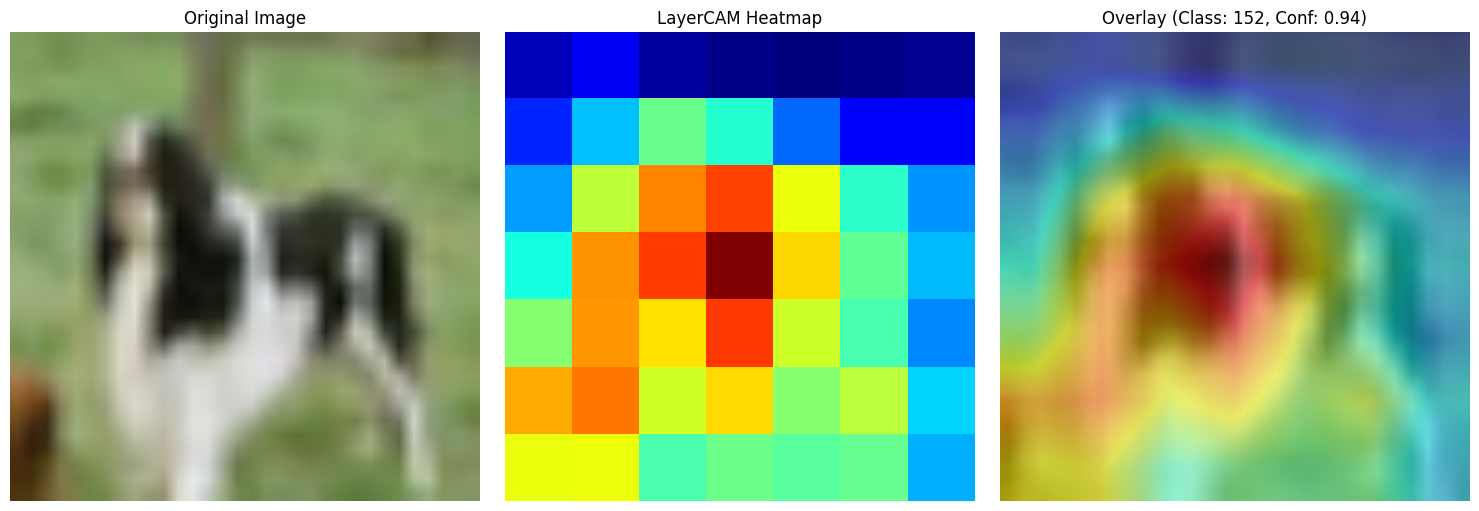


Visualization complete


In [7]:
# Create visualization
overlay = layercam.visualize(image_tensor, cam, alpha=0.5)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image_pil)
axes[0].set_title('Original Image', fontsize=12)
axes[0].axis('off')

# Heatmap only
axes[1].imshow(cam, cmap='jet')
axes[1].set_title('LayerCAM Heatmap', fontsize=12)
axes[1].axis('off')

# Overlay
axes[2].imshow(overlay)
axes[2].set_title(f'Overlay (Class: {pred_class}, Conf: {confidence:.2f})', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\nVisualization complete")

## Compare with Standard Grad-CAM

In [8]:
# Simple Grad-CAM for comparison
class SimpleGradCAM:
    def __init__(self, model, target_layer, device='cpu'):
        self.model = model.to(device)
        self.target_layer = target_layer
        self.device = device
        self.gradients = None
        self.activations = None
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)
    
    def generate_cam(self, image, target_class=None):
        self.model.eval()
        image = image.to(self.device)
        image.requires_grad = True
        output = self.model(image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        self.model.zero_grad()
        target_score = output[0, target_class]
        target_score.backward()
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
        return cam
    
    def visualize(self, cam, alpha=0.5):
        # simple visualize for comparison
        h, w = 224, 224
        cam_resized = cv2.resize(cam, (w, h)).copy()
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        return heatmap / 255.0

# Generate Grad-CAM
gradcam = SimpleGradCAM(model, target_layer, device)
start_time = time.time()
gradcam_result = gradcam.generate_cam(image_tensor, pred_class)
gradcam_time = time.time() - start_time

print(f"Generated Grad-CAM for comparison")
print(f"Generation time: {gradcam_time:.3f}s")
print(f"\nSpeed comparison:")
print(f"  Grad-CAM: {gradcam_time:.3f}s")
print(f"  LayerCAM: {generation_time:.3f}s")
print(f"  Similar computational cost")

Generated Grad-CAM for comparison
Generation time: 0.061s

Speed comparison:
  Grad-CAM: 0.061s
  LayerCAM: 0.093s
  Similar computational cost


## Visualize Comparison

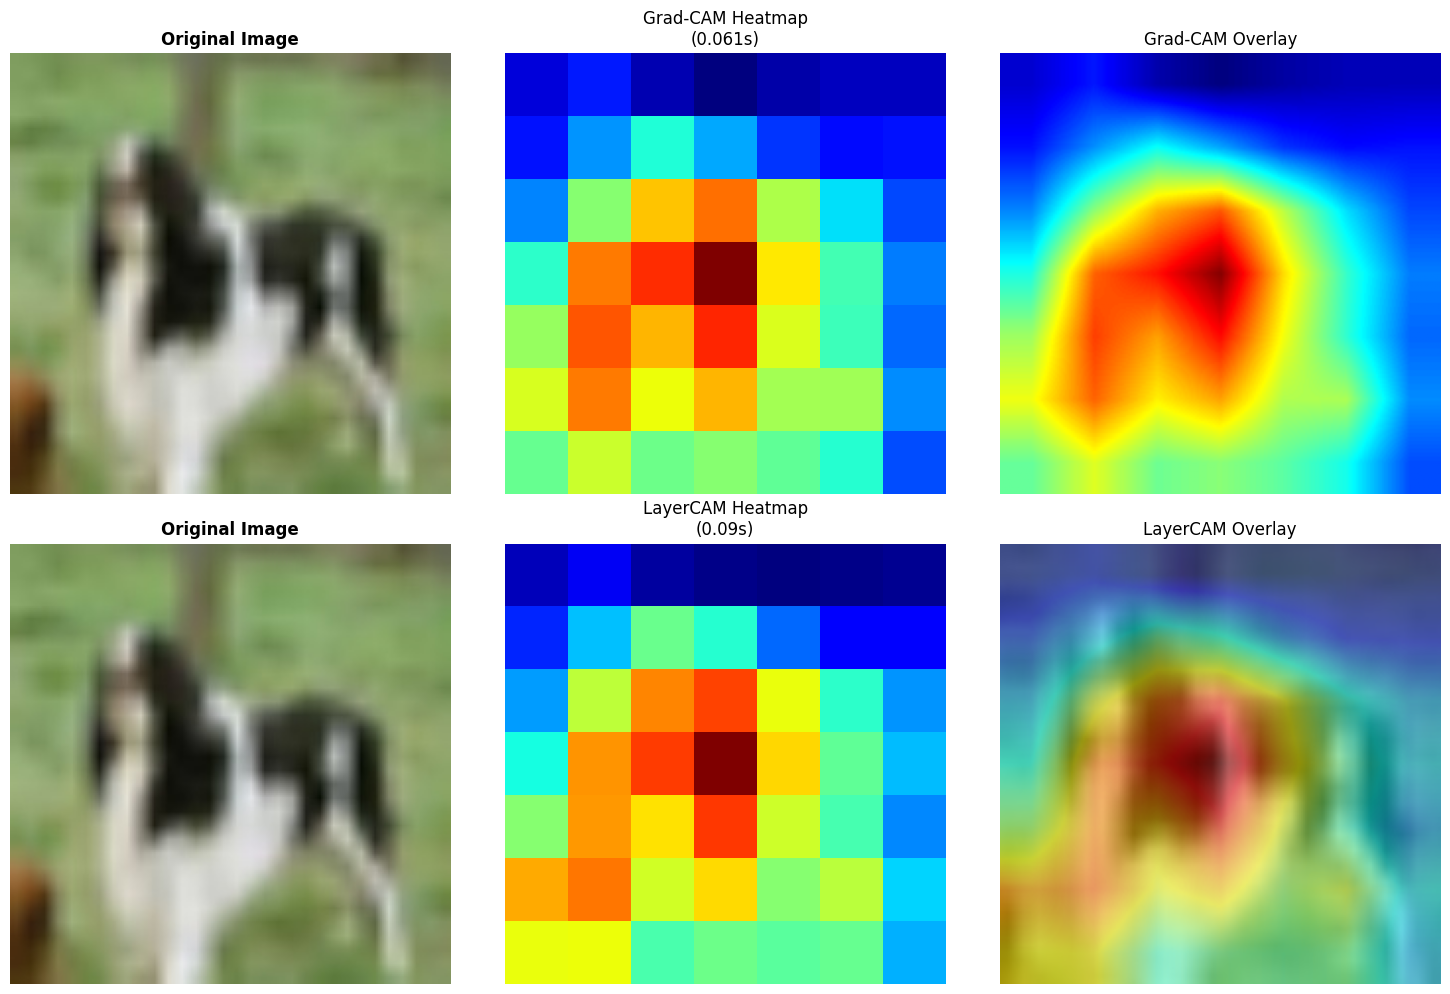


Comparison visualization complete

Key differences:
  - LayerCAM: Element-wise gradient weighting
  - LayerCAM: Better spatial precision
  - LayerCAM: Same computational cost as Grad-CAM


In [9]:
# Create overlays
gradcam_overlay = gradcam.visualize(gradcam_result, alpha=0.5)
layercam_overlay = layercam.visualize(image_tensor, cam, alpha=0.5)

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Grad-CAM
axes[0, 0].imshow(image_pil)
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(gradcam_result, cmap='jet')
axes[0, 1].set_title(f'Grad-CAM Heatmap\n({gradcam_time:.3f}s)', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(gradcam_overlay)
axes[0, 2].set_title('Grad-CAM Overlay', fontsize=12)
axes[0, 2].axis('off')

# Row 2: LayerCAM
axes[1, 0].imshow(image_pil)
axes[1, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(cam, cmap='jet')
axes[1, 1].set_title(f'LayerCAM Heatmap\n({generation_time:.2f}s)', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(layercam_overlay)
axes[1, 2].set_title('LayerCAM Overlay', fontsize=12)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\nComparison visualization complete")
print("\nKey differences:")
print("  - LayerCAM: Element-wise gradient weighting")
print("  - LayerCAM: Better spatial precision")
print("  - LayerCAM: Same computational cost as Grad-CAM")

## Process Multiple Images

Processing 4 images with LayerCAM

Image 1/4: real_012_dog.jpg...
  Done in 0.06s
Image 2/4: real_002_dog.jpg...
  Done in 0.06s
Image 3/4: real_018_automobile.jpg...
  Done in 0.06s
Image 4/4: real_017_ship.jpg...
  Done in 0.06s


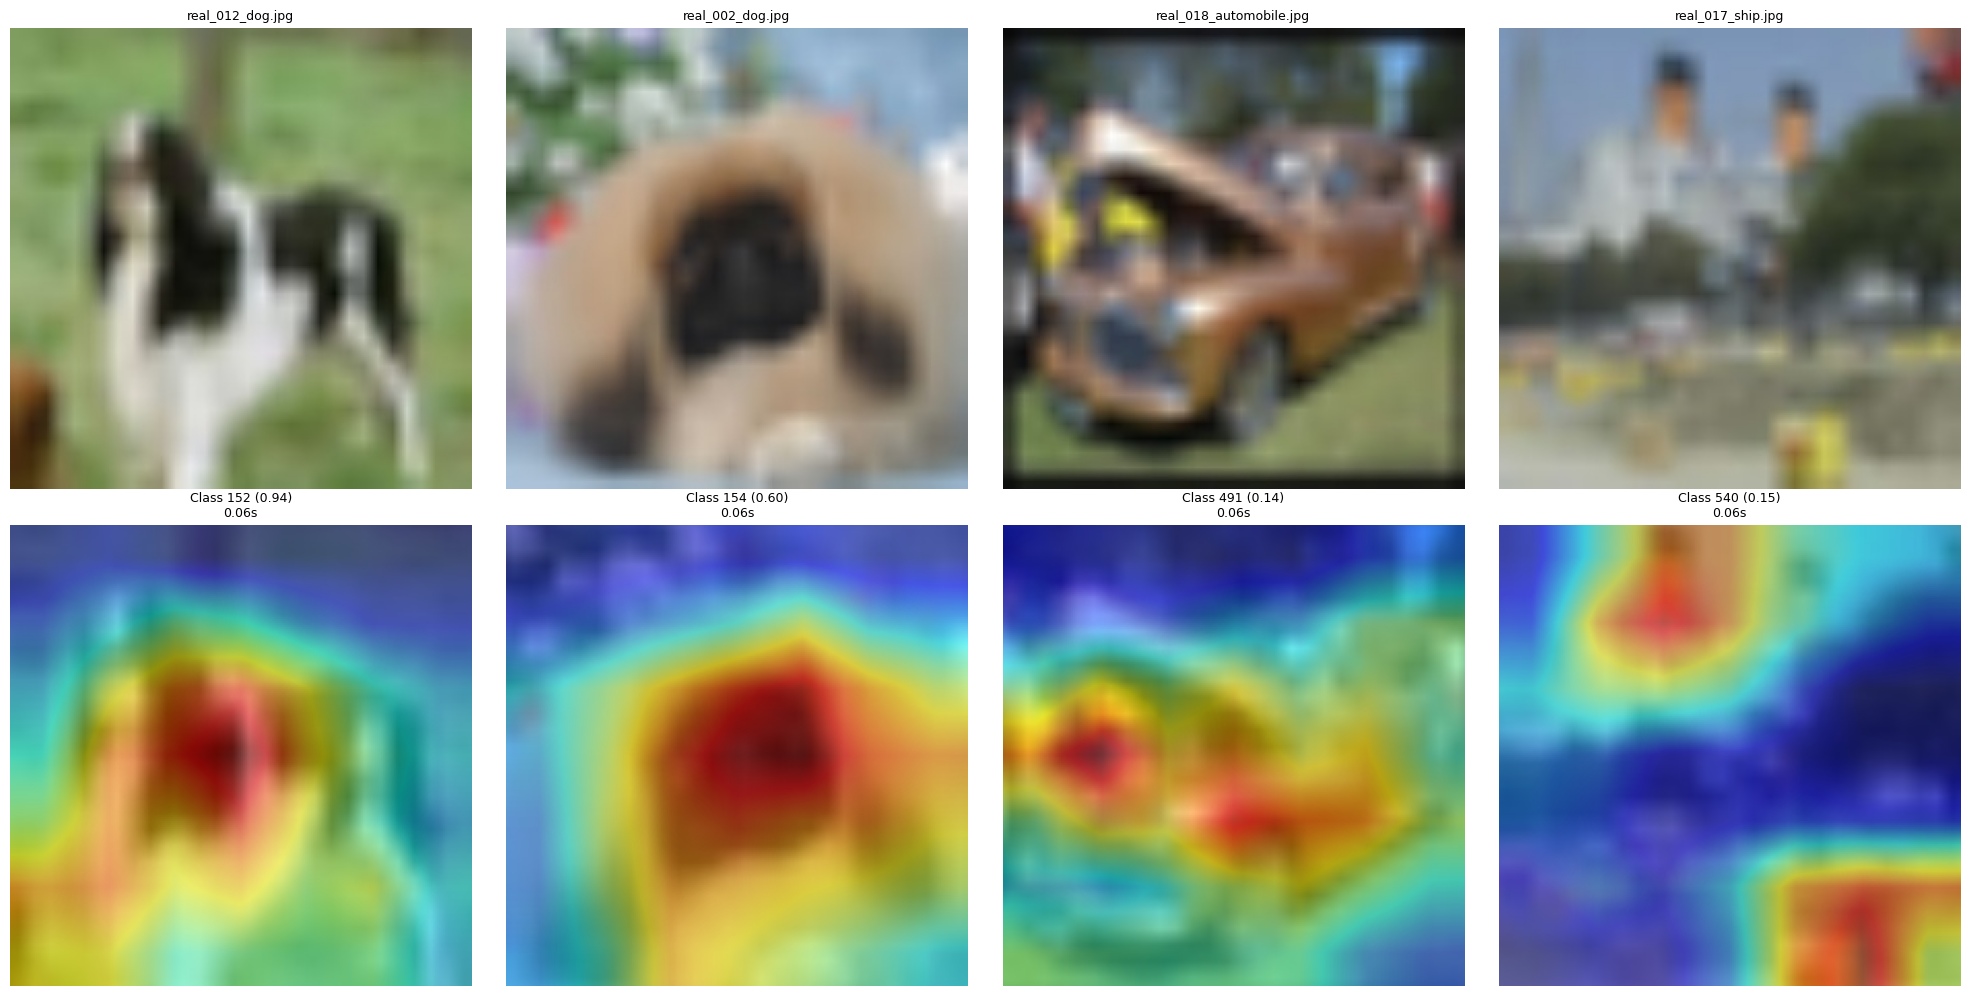


Processed 4 images


In [10]:
# Process first 4 images
num_images = min(4, len(image_files))

fig, axes = plt.subplots(2, num_images, figsize=(5*num_images, 10))
if num_images == 1:
    axes = axes.reshape(-1, 1)

print(f"Processing {num_images} images with LayerCAM\n")

for idx in range(num_images):
    # Load image
    img_pil = Image.open(image_files[idx]).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0)
    
    # Generate CAM
    print(f"Image {idx+1}/{num_images}: {image_files[idx].name}...")
    start = time.time()
    cam = layercam.generate_cam(img_tensor)
    elapsed = time.time() - start
    print(f"  Done in {elapsed:.2f}s")
    
    overlay = layercam.visualize(img_tensor, cam, alpha=0.5)
    
    # Get prediction
    with torch.no_grad():
        output = model(img_tensor.to(device))
        pred_class = output.argmax(dim=1).item()
        conf = torch.softmax(output, dim=1)[0, pred_class].item()
    
    # Plot original
    axes[0, idx].imshow(img_pil)
    axes[0, idx].set_title(f'{image_files[idx].name}', fontsize=9)
    axes[0, idx].axis('off')
    
    # Plot overlay
    axes[1, idx].imshow(overlay)
    axes[1, idx].set_title(f'Class {pred_class} ({conf:.2f})\n{elapsed:.2f}s', fontsize=9)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\nProcessed {num_images} images")

## Save Sample Results

In [11]:
# Create output directory
output_dir = Path('results/layercam_examples')
output_dir.mkdir(parents=True, exist_ok=True)

# Save first image results
image_pil = Image.open(image_files[0]).convert('RGB')
image_tensor = transform(image_pil).unsqueeze(0)
cam = layercam.generate_cam(image_tensor)
overlay = layercam.visualize(image_tensor, cam, alpha=0.5)

# Save overlay
plt.imsave(output_dir / 'layercam_overlay.png', overlay)
plt.imsave(output_dir / 'layercam_heatmap.png', cam, cmap='jet')

print(f"Saved results to: {output_dir}")
print(f"  layercam_overlay.png")
print(f"  layercam_heatmap.png")

Saved results to: results/layercam_examples
  layercam_overlay.png
  layercam_heatmap.png


---

## Paper Citation

**LayerCAM: Exploring Hierarchical Class Activation Maps for Localization**

Jiang et al., IEEE TIP 2021

Paper: https://ieeexplore.ieee.org/document/9462463

**Key Contributions**:
- Element-wise gradient weighting instead of global average pooling
- Better spatial precision for localization
- Handles multiple objects better than Grad-CAM
- Same computational efficiency as Grad-CAM

---

## Method Comparison

| Aspect | Grad-CAM | LayerCAM |
|--------|----------|-----------|
| **Speed** | ~0.05s | ~0.05s |
| **Weighting** | Global average | Element-wise |
| **Spatial precision** | Coarse | Better |
| **Computational cost** | 1 forward + 1 backward | 1 forward + 1 backward |

---

## Next Steps

Run the next notebook: **4_hybrid_gradcam_layercam.ipynb**